---
## Logic
A person announces that she has chosen two whole numbers $x,y$ between $2$ and $99$ (inclusive) and has computed their product $p$ and their sum $s$. She then separately reveals the value of $p$ to person **P** and the value of $s$ to person **S**. Then **P** and **S** have the following conversation:
* **S** : I know you can't determine numbers $x$ and $y$.
* **P** : In that case, I can determine them.
* **S** : In that case, I can determine them too.

What are the numbers $x,y$.

### solution:

In [1]:
def solution(): # brute force
  from collections import defaultdict

  E = set((x,y) for x in range(2,100) for y in range(x,100))

  p = defaultdict(int); s = defaultdict(set)
  for u,v in E: p[u*v] += 1; s[u+v].add((u,v))
  E1 = set.union(*(l for l in s.values() if all(p[u*v]>1 for (u,v) in l)))

  p = defaultdict(int)
  for u,v in E1: p[u*v] += 1
  E2 = set((x,y) for x,y in E1 if p[x*y] == 1)

  s = defaultdict(int)
  for u,v in E2: s[u+v] += 1
  E3 = set((x,y) for x,y in E2 if s[x+y] == 1)

  return E,E1,E2,E3

In [2]:
E,E1,E2,E3 = solution()
print(f'|E|={len(E)}   |E1|={len(E1)}   |E2|={len(E2)}   E3={E3}')

|E|=4851   |E1|=145   |E2|=86   E3={(4, 13)}


---
## Optimisation
A lorry must cross a desert on a unique track. Its total capacity is one unit of fuel. It can move on the track in both directions, and burns one unit of fuel per unit of distance, whatever its load. It can also constitute reserves along the track, and load from them later on (evaporation and losses are neglected). What is the minimal amount of fuel required at the starting point to reach a point at 2 distance units on the track.

---
## Optimisation
12 coins all have the same weight except one. Determine the distinguished one using only 3 weighings with a balance scale and no reference weights. Determine if it is heavier or lighter.

### solution:
The coins are indexed $\{1,2,3,4,5,6,7,8,9,A,B,C\}$.

* The result of weighing sets $U$ and $V$ of coins is denoted $U|V$ and can be either $+1$ if $U$ is heavier than $V$, or $-1$ is $U$ is lighter, or $0$ if they have the same weight.
* A configuration is a pair denoted $x^\omega$ where $x$ is the index of the distinguished coin, and $\omega$ indicates whether it is heavier ($\omega=+$) or lighter ($\omega=-$) than the others.
* A test (class ``Test``) is a decision tree where each decision node holds a weighing probe and the outgoing edges from that node are labelled with the possible outcomes of that probe. Each configuration can be sifted through a test and returns the decision path it follows.
* A solution is a test of depth at most 3 where the decision paths of any pair of distinct configurations are distinct.

There are only $24$ configurations altogether, and a test of depth $3$ has $3^3=27\geq24$ full paths (since the branching factor is $3$), so finding a solution may not be impossible. An optimal solution (a test which minimises the number pairs of configurations sharing the same desicion path) is constructed incrementally by assigning a weighing probe to each node in the tree, according to the principle of maximum information gain: given the set of configurations which have reached a given node on their decision path, the wheighing probe at that node is chosen so that it distributes them as uniformly as possible over its three outgoing edges. The search space is considerably reduced by symmetry considerations.

In [1]:
from collections import defaultdict
class Test:
  coins = '123456789ABC'
  dcoins = dict((c,n) for n,c in enumerate(coins))
  def genconfs(coins=coins):
    l = len(coins)*[0]
    for n,c in enumerate(coins):
      l[n] = 1; yield c+'+',tuple(l)
      l[n] = -1; yield c+'-',tuple(l)
      l[n] = 0
  allconfs = list(genconfs())
  def __init__(self,label,branches={}):
    self.label = label
    self.compare = tuple(tuple(self.dcoins[c] for c in tx) for tx in label.split('|'))
    assert len(self.compare)==2
    self.branches = branches
  def sift(self,L=allconfs):
    scale1,scale2 = self.compare
    D = defaultdict(list)
    for u,x in L:
      r = 0
      for i in scale1: r += x[i]
      for i in scale2: r -= x[i]
      D[r].append((u,x))
    branches = {}
    for r,Lr in D.items():
      x = self.branches.get(r)
      branches[r] = Lr if x is None else x.sift(Lr)
    return Sift(self.label,L,branches)

class Sift:
  def __init__(self,label,sols,branches):
    self.label,self.sols,self.branches=label,sols,branches
  def __str__(self):
    return ''.join(self.astxt())
  def _repr_html_(self):
    from lxml.etree import tostring
    return tostring(self.ashtml(),encoding=str)
  def astxt(self,indent=''):
    yield '({}) >> {}?'.format(len(self.sols),self.label)
    indent += '  '
    indent2 = indent+'  '
    for r in 1,-1,0:
      yield '\n{}{:2}:'.format(indent,r)
      sift = self.branches.get(r)
      if isinstance(sift,Sift):
        yield from sift.astxt(indent2)
      else:
        if sift is None: sift = ()
        yield '({}) [{}]'.format(len(sift),','.join(u for u,_ in sift))
  def ashtml(self):
    from lxml.builder import E
    def td(*a,style='',**ka):
      return E.td(*a,style=style+' text-align: left; border-top:thin solid black; border-bottom:thin solid black; border-left:thin solid black; background-color: white;',**ka)
    def label(r):
      if r!=1: return ''
      return td(
        E.span(str(len(self.sols)),title=','.join(u for u,_ in self.sols)),
        '>> ',
        E.span(self.label,style='font-weight: bold; color: blue;'),
        '?',
        rowspan='3')
    def sub(r):
      sift = self.branches.get(r)
      if sift is None: return td()
      if isinstance(sift,Sift): return td(sift.ashtml(),style='padding:0;')
      else: return td(*(E.span(u[0],E.span(u[1],style='vertical-align: super;'),' ',style='font-weight: bold') for u,_ in sift))
    return E.table(*(E.tr(label(r),td(str(r)),sub(r)) for r in (1,-1,0)),style='border-collapse: collapse;')
  def aspgf(self):
    def probe(s,name='N',x=0):
      nonlocal y
      yield r'\node[probe] (%s) at (%g,%g) {$%s$ {\tt >>} {\bf %s}?};%s' % (name,x,y,len(s.sols),s.label,'\n')
      for k,r in enumerate((1,-1,0)):
        if k != 0: y -= .35
        sift = s.branches.get(r)
        if isinstance(sift,Sift): yield from probe(sift,name+str(k),x+3.5)
        else:
          z = '*' if sift is None else ' '.join(r'\textbf{%s}^{%s}' % (u[0],u[1]) for u,_ in sift)
          yield r'\node[sol] (%s%s) at (%g,%g) {$%s$};%s' % (name,k,x+3.5,y,z,'\n')
        yield r'\draw[->] (%s.%s) to node[outcome] {\tiny $%s$} (%s%s.west);' % (name,('east' if k==0 else 'south'),r,name,k)
    y = 0
    return ''.join(probe(self))

In [2]:
test = Test(
  '1234|5678',
  {
    1:Test('129|345',{1:Test('1|2'),-1:Test('3|4'),0:Test('6|7')}),
    -1:Test('569|178',{1:Test('5|6'),-1:Test('7|8'),0:Test('2|3')}),
    0:Test('9A|B1',{1:Test('9|A'),-1:Test('9|A'),0:Test('C|1')}),
  }
)
sift = test.sift()
sift

In [ ]:
print(sift.aspgf())

---
## Geometry
Let $R$ be a rectangle and $a,b$ its sides. A rectangle with sides $x,y$ is said to be *inscribed* in $R$ if all its vertices are on the sides of $R$. Which relation links $x,y,a,b$ in that case ? How many rectangles with at least one side equal to $a$ are inscribed in $R$ ?

### solution:

In [1]:
%matplotlib notebook
from numpy import linspace, pi, sin, cos, tan, square, sqrt
from ipywidgets import Play, FloatSlider, VBox, Output
from matplotlib.pyplot import subplots
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D

<IPython.core.display.Javascript object>


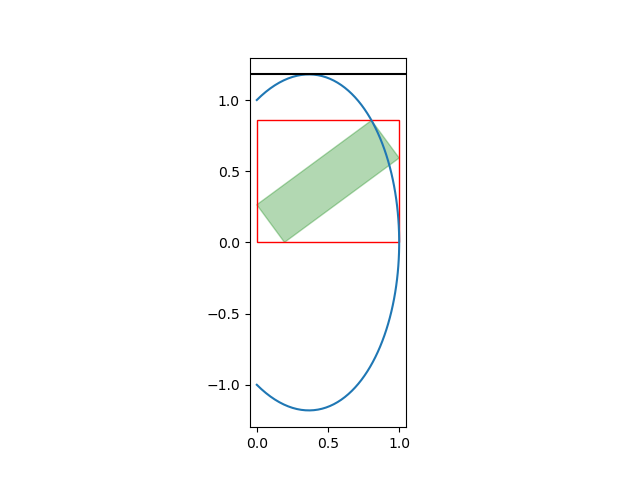

FloatSlider(value=0.0, max=1.5707963267948966, min=-1.5707963267948966, step=0.005)

In [2]:
a = linspace(-pi/2,pi/2,100)
fig,ax = subplots()
ax.set(aspect='equal')
r_in = Rectangle((0,0),1,0,color='green',alpha=.3)
ax.add_patch(r_in)
r_out = Rectangle((0,0),1,0,edgecolor='red',facecolor='none')
ax.add_patch(r_out)
x = cos(a)
y = .25*sin(2*a)/square(cos(.5*a))+sin(a)
ax.plot(x,y)
ax.axhline(3/sqrt(2*sqrt(3)+3),c='k')
def disp():
  a = w_a.value
  t = Affine2D().rotate(a).translate(1-cos(a),0)
  r_in.set(transform=t+ax.transData,height=tan(a/2))
  r_out.set(height=.25*sin(2*a)/square(cos(.5*a))+sin(a))
w_a = FloatSlider(min=-pi/2,max=pi/2,step=.005)
w_a.observe(lambda c: disp())
display(w_a)